In [1]:
"""
Title: Image classification with transfer learning using a fine tuned MobileNetV3Large
Author: Maya Seale
Date created: 2023/11/03
Last modified: 2023/11/03

"""

'\nTitle: Image classification with transfer learning using a fine tuned MobileNetV3Small\nAuthor: Maya Seale\nDate created: 2023/11/03\nLast modified: 2023/11/03\n\n'

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import csv
import matplotlib.pyplot as plt
from matplotlib import figure
import numpy
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import classification_report
import seaborn as sns


In [3]:
url = "https://storage.googleapis.com/doggies-doggies/Monkeys.zip"
pathto = "/content/monkey"
path = keras.utils.get_file("Monkeys.zip",origin = url)
import zipfile
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(pathto)



In [4]:
train_dir = os.path.join(pathto, 'training/training')
validation_dir = os.path.join(pathto, 'validation/validation')
train_dataset = tf.keras.utils.image_dataset_from_directory( train_dir, labels="inferred",color_mode="rgb", image_size=(160,160), batch_size= 30)

Found 1097 files belonging to 10 classes.


In [5]:

validation_dataset = tf.keras.utils.image_dataset_from_directory( validation_dir, labels="inferred",color_mode="rgb", image_size=(160,160), batch_size= 30)

Found 272 files belonging to 10 classes.


In [6]:

train_dataset.class_names = ["Mantled Howler","Patas Monkey","Bald Uakari","Japanese Macaque", "Pygmy Marmoset","White Headed Capuchin","Silvery Marmoset", "Common Squirrel Monkey", "Black Headed Night Monkey","Nilgiri Langur"]


# Understanding the Dataset

In [7]:

# Retrieve the class names from the dataset
class_names = train_dataset.class_names

# Dictionary to store the count of each class
class_counts = {class_name: 0 for class_name in class_names}

# Iterate through the dataset to count occurrences of each class
for data in train_dataset:

    _, labels = data  # Extracting labels from the dataset
    for label in labels.numpy():
        label = label.item()

        class_counts[class_names[label]] += 1
for data in validation_dataset:

    _, labels = data
    for label in labels.numpy():
        label = label.item()

        class_counts[class_names[label]] += 1


In [8]:
from tabulate import tabulate

table = []
for class_name, count in class_counts.items():
    table.append([class_name, count])

# Display the dictionary as a table using tabulate
print(tabulate(table, headers=["Species Name", "Count"], tablefmt="grid"))

+---------------------------+---------+
| Species Name              |   Count |
+===========================+=========+
| Mantled Howler            |     131 |
+---------------------------+---------+
| Patas Monkey              |     139 |
+---------------------------+---------+
| Bald Uakari               |     137 |
+---------------------------+---------+
| Japanese Macaque          |     152 |
+---------------------------+---------+
| Pygmy Marmoset            |     131 |
+---------------------------+---------+
| White Headed Capuchin     |     141 |
+---------------------------+---------+
| Silvery Marmoset          |     132 |
+---------------------------+---------+
| Common Squirrel Monkey    |     142 |
+---------------------------+---------+
| Black Headed Night Monkey |     133 |
+---------------------------+---------+
| Nilgiri Langur            |     131 |
+---------------------------+---------+


In [9]:
for data in train_dataset:
    # Assuming the dataset yields tuples of (features, labels), modify accordingly
    _, labels = data  # Extracting labels from the dataset
    for label in labels.numpy():
        label = label.tostring
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

# Display the count of each class
print("Number of data points for each class:")
print(class_counts)

Number of data points for each class:
{'Mantled Howler': 131, 'Patas Monkey': 139, 'Bald Uakari': 137, 'Japanese Macaque': 152, 'Pygmy Marmoset': 131, 'White Headed Capuchin': 141, 'Silvery Marmoset': 132, 'Common Squirrel Monkey': 142, 'Black Headed Night Monkey': 133, 'Nilgiri Langur': 131, <built-in method tostring of numpy.int32 object at 0x7cdef06fb670>: 1, <built-in method tostring of numpy.int32 object at 0x7cdef06fb750>: 1, <built-in method tostring of numpy.int32 object at 0x7cdef06fb770>: 1, <built-in method tostring of numpy.int32 object at 0x7cdef06fb730>: 1, <built-in method tostring of numpy.int32 object at 0x7cdef06fb550>: 1, <built-in method tostring of numpy.int32 object at 0x7cdef06fa550>: 1, <built-in method tostring of numpy.int32 object at 0x7cdef06fb8f0>: 1, <built-in method tostring of numpy.int32 object at 0x7cdef06fb7f0>: 1, <built-in method tostring of numpy.int32 object at 0x7cdef06fb6d0>: 1, <built-in method tostring of numpy.int32 object at 0x7cdef06fb7d0>:

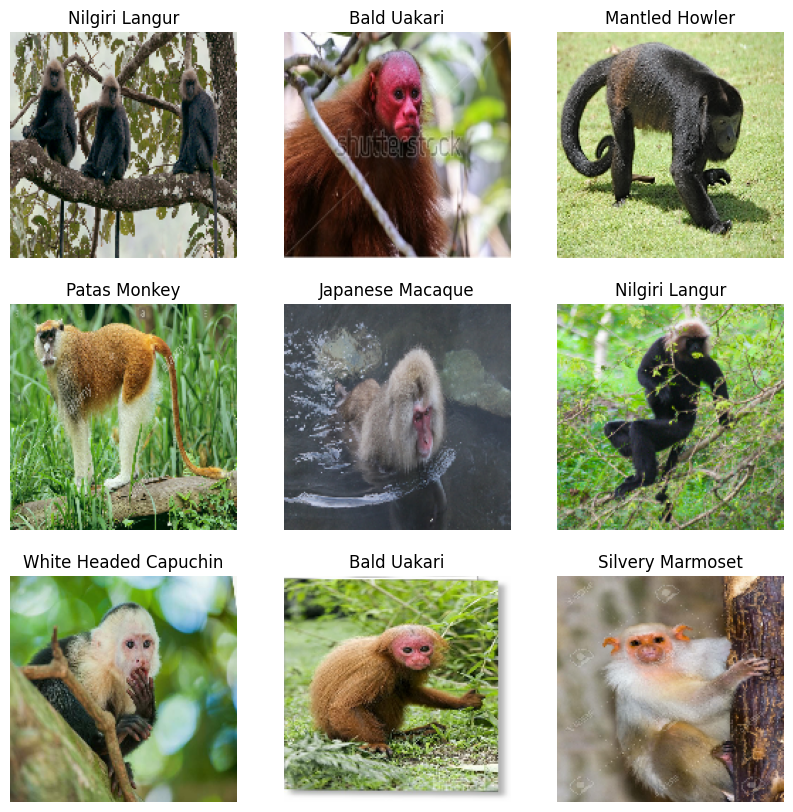

In [10]:
class_names = train_dataset.class_names
{'n0': "Mantled Howler", 'n1': "Patas Monkey", 'n2': "Bald Uakari", 'n3': "Japanese Macaque", 'n4': "Pygmy Marmoset",'n5': "White Headed Capuchin", 'n6': "Silvery Marmoset", 'n7': "Common Squirrel Monkey", 'n8': "Black Headed Night Monkey",'n9': "Nilgiri Langur"}
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=10>

In [12]:
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5) # Skip the data taken out for test datat
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 2


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#Creating Model Without Fine Tuning

In [14]:
IMG_SIZE=(160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                                    include_preprocessing=True)


12683000/12683000 [==============================] - 2s 0us/step


In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(30, 5, 5, 960)


In [16]:
# Freezing the base model
base_model.trainable = False

In [17]:
# Looking at the base model architecture
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 160, 160, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 80, 80, 16)           432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 80, 80, 16)           64        ['Conv[0][0]']                
 lization)                                                                         

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(30, 960)


In [19]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(30, 10)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))

x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 5, 5, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 10)                9610      
                                                                 
Total params: 3005962 (11.47 MB)
Trainable params: 9610 (37.5

In [24]:
# Lets see how many trainable variables we have
len(model.trainable_variables)


2

In [25]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 [==============================] - 6s 95ms/step - loss: 2.8454 - accuracy: 0.1274


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.85
initial accuracy: 0.13


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
37/37 [==============================] - 20s 340ms/step - loss: 2.7742 - accuracy: 0.1714 - val_loss: 2.2102 - val_accuracy: 0.2453
Epoch 2/10
37/37 [==============================] - 15s 350ms/step - loss: 2.1766 - accuracy: 0.2716 - val_loss: 1.7809 - val_accuracy: 0.3868
Epoch 3/10
37/37 [==============================] - 15s 348ms/step - loss: 1.7933 - accuracy: 0.3619 - val_loss: 1.4763 - val_accuracy: 0.4906
Epoch 4/10
37/37 [==============================] - 15s 346ms/step - loss: 1.4958 - accuracy: 0.4822 - val_loss: 1.2758 - val_accuracy: 0.5708
Epoch 5/10
37/37 [==============================] - 15s 346ms/step - loss: 1.2474 - accuracy: 0.5761 - val_loss: 1.0439 - val_accuracy: 0.6745
Epoch 6/10
37/37 [==============================] - 15s 343ms/step - loss: 1.0738 - accuracy: 0.6600 - val_loss: 0.8781 - val_accuracy: 0.7925
Epoch 7/10
37/37 [==============================] - 15s 349ms/step - loss: 0.9043 - accuracy: 0.7211 - val_loss: 0.7716 - val_accuracy: 0.8208

##Performance Evaluation

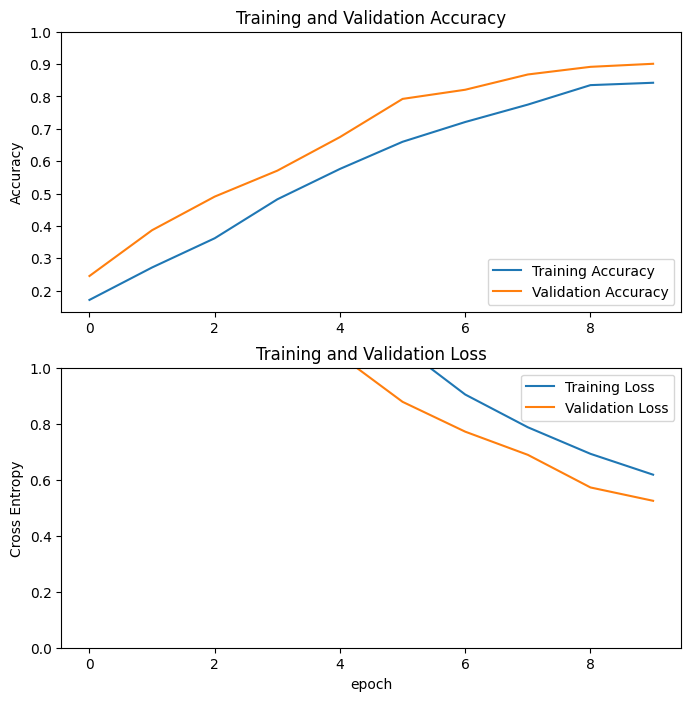

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 1s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


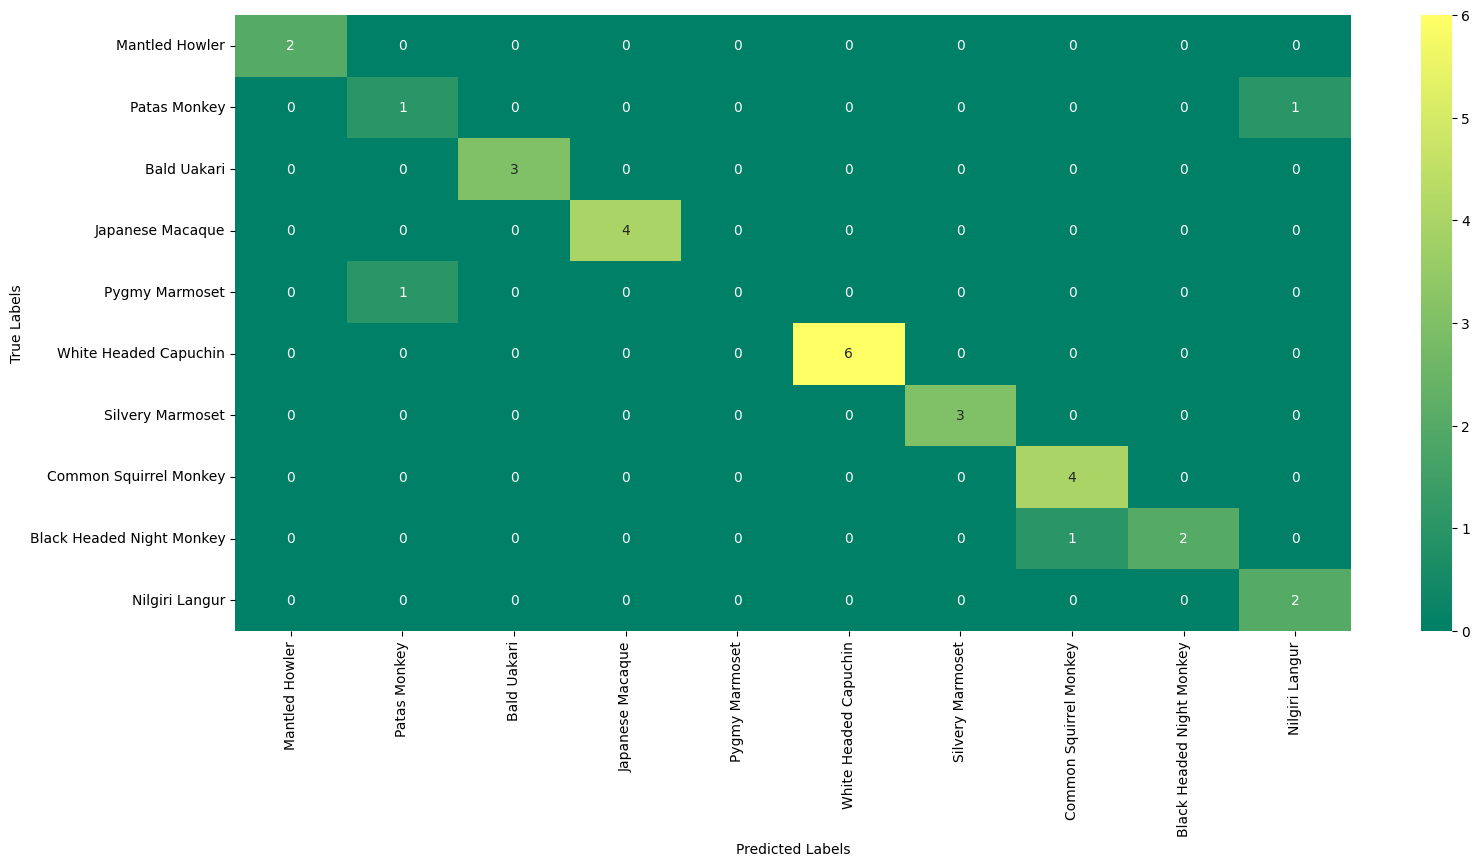

In [29]:

# Accuracy
loss0, accuracy = model.evaluate(test_dataset, batch_size = 54)
# F1 Score
for images, labels in test_dataset.take(-1):
    x_test = images
    y_true = labels
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
f1total = f1_score(y_true,  y_pred, average='macro')
# F1 score by species
report = classification_report(y_true, y_pred)

# Confusion Matricx
plt.figure(figsize = (18,8))
sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot = True, xticklabels = class_names, yticklabels = class_names, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [30]:
print('Test accuracy :', accuracy)
print('F1 Score :', f1total)
print(report)

Test accuracy : 0.8999999761581421
F1 Score : 0.7988888888888889
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.50      0.50      0.50         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         3
           7       0.80      1.00      0.89         4
           8       1.00      0.67      0.80         3
           9       0.67      1.00      0.80         2

    accuracy                           0.90        30
   macro avg       0.80      0.82      0.80        30
weighted avg       0.88      0.90      0.89        30



# Fine Tuning

In [31]:
base_model.trainable = True

In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  263


In [33]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 5, 5, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 10)                9610      
                                                                 
Total params: 3005962 (11.47 MB)
Trainable params: 2871962 (1

In [35]:
len(model.trainable_variables)

94

In [36]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
37/37 [==============================] - 29s 371ms/step - loss: 0.4556 - accuracy: 0.8879 - val_loss: 0.3530 - val_accuracy: 0.9245
Epoch 11/20
37/37 [==============================] - 15s 362ms/step - loss: 0.3002 - accuracy: 0.9298 - val_loss: 0.2726 - val_accuracy: 0.9340
Epoch 12/20
37/37 [==============================] - 15s 360ms/step - loss: 0.2067 - accuracy: 0.9544 - val_loss: 0.1987 - val_accuracy: 0.9528
Epoch 13/20
37/37 [==============================] - 16s 362ms/step - loss: 0.1628 - accuracy: 0.9635 - val_loss: 0.1975 - val_accuracy: 0.9575
Epoch 14/20
37/37 [==============================] - 15s 361ms/step - loss: 0.1317 - accuracy: 0.9635 - val_loss: 0.1798 - val_accuracy: 0.9575
Epoch 15/20
37/37 [==============================] - 15s 362ms/step - loss: 0.0893 - accuracy: 0.9799 - val_loss: 0.1449 - val_accuracy: 0.9670
Epoch 16/20
37/37 [==============================] - 15s 364ms/step - loss: 0.0704 - accuracy: 0.9809 - val_loss: 0.1576 - val_accuracy:

##Performance Evaluation

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

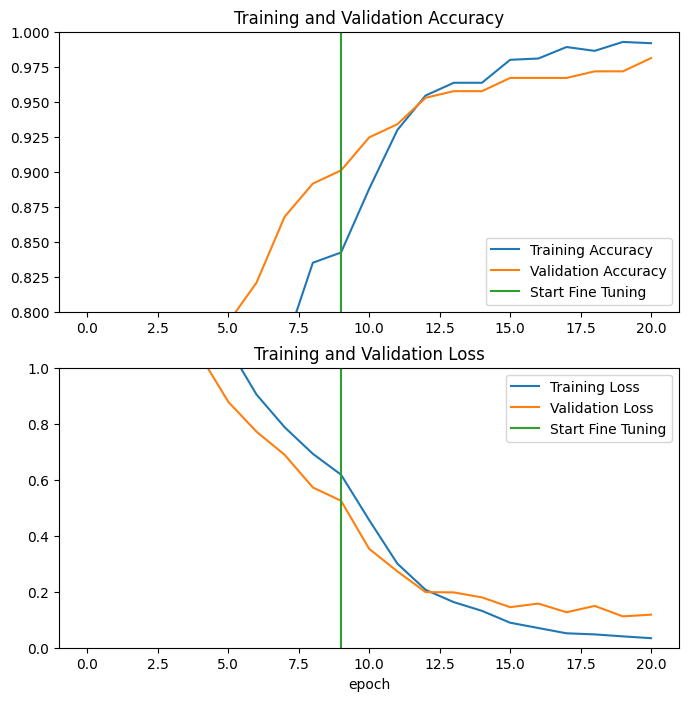

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 1s 1s/step


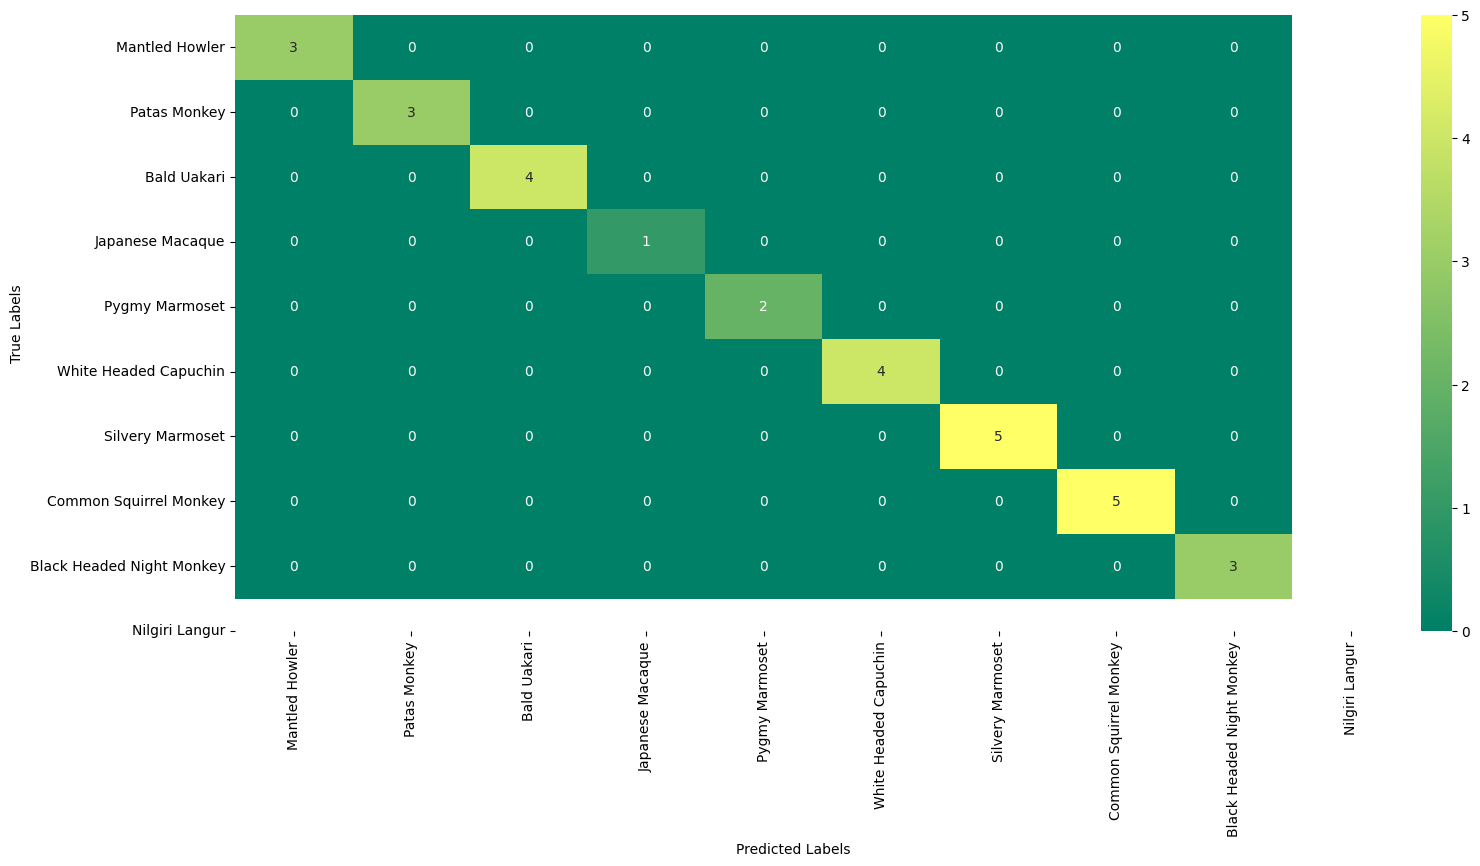

In [39]:

# Accuracy
loss, accuracy = model.evaluate(test_dataset, batch_size = 54)
# F1 Score
for images, labels in test_dataset.take(-1):
    x_test = images
    y_true = labels
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
f1total = f1_score(y_true,  y_pred, average='macro')
# F1 score by species
report = classification_report(y_true, y_pred)

# Confusion Matricx
plt.figure(figsize = (18,8))
sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot = True, xticklabels = class_names, yticklabels = class_names, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [40]:
print('Test accuracy :', accuracy)
print('F1 Score :', f1total)
print(report)

Test accuracy : 0.9666666388511658
F1 Score : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



1/1 [==============================] - 0s 30ms/step
Predictions:



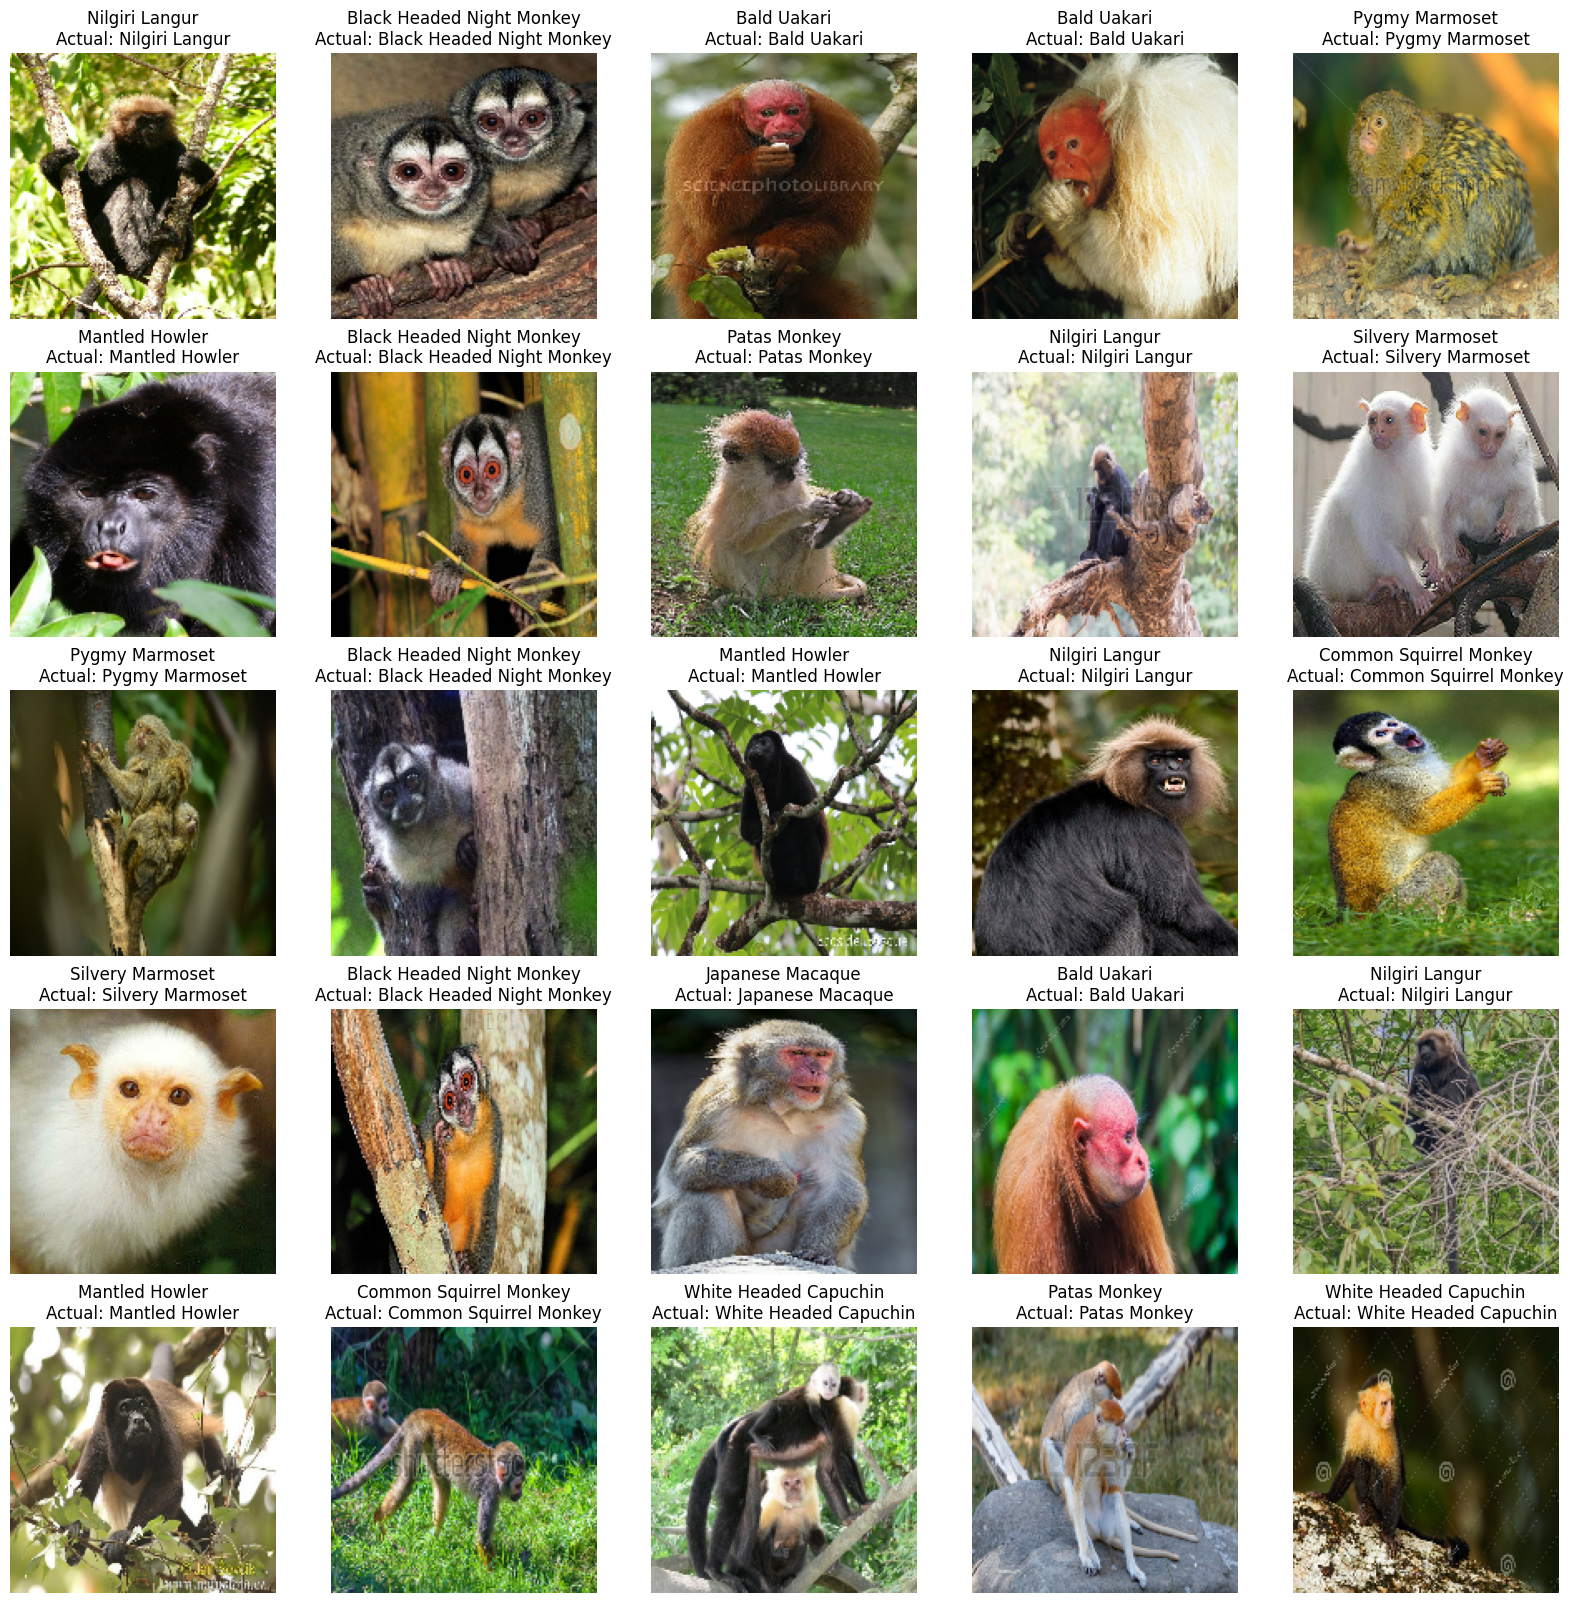

In [41]:
import numpy as np
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Apply a sigmoid since our model returns logits
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.ThresholdedReLU(theta=.5)])
predictions = model.predict(image_batch)

print('Predictions:\n')
a = np.empty(len(predictions))
for i in predictions:
  sx = np.argmax(i)
  a = np.append(a, sx)
plt.figure(figsize=(20, 20))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title( class_names[np.argmax(predictions[i])] + "\n" + "Actual: " + class_names[(label_batch[i])])
  plt.axis("off")



